# Notebook 4: Dynamic Nelson-Siegel (DNS) Model
# Author: Will Wu

---

## **Table of Contents** ##

1. [Introduction](#1)
2. [Loading and Setup](#2)
3. [PCA and Factor Extraction](#3)
4. [Stationarity Testing](#4)
5. [Modeling Setup & Rolling Window Validation](#5)
6. [Results & Next Steps](#6)

---


## 1. Introduction <a class="anchor" id="1"></a>

In this notebook, we implement and evaluate a **Dynamic Nelson–Siegel (DNS)** model to forecast the entire yield curve based on its underlying factors. Unlike purely statistical models, the DNS framework is **structural and economic**, decomposing the yield curve into **latent factors**— Level, Slope, and Curvature—that evolve smoothly over time.

---

### What is the Dynamic Nelson–Siegel (DNS) Model?

The DNS model models the yield curve as a **time-varying combination** of three latent factors:

- **Level (β₀):** Represents the overall level of interest rates across maturities.
- **Slope (β₁):** Captures the steepness or flatness of the yield curve.
- **Curvature (β₂):** Describes the convexity or "bend" of the curve.

Mathematically, the yield $y(t, T)$ at time $t$ and maturity $T$ is modeled as:

$$y(t, T) = \beta_{0t} + \beta_{1t} \cdot \frac{1 - e^{-\lambda T}}{\lambda T} + \beta_{2t} \left(\frac{1 - e^{-\lambda T}}{\lambda T} - e^{-\lambda T}\right)$$

Where:

$y(t, T)$ is the yield at time $t$ for maturity $T$.

$\beta_{0t}$ (Level) is the long-term yield.

$\beta_{1t}$ (Slope) captures the short-term vs. long-term difference.

$\beta_{2t}$ (Curvature) captures the hump or trough in the middle of the curve.

$\lambda$ is a decay parameter controlling how quickly the Slope and Curvature components decay to zero.

The three terms that multiply the $\beta$ factors ($\beta_{0t}$, $\beta_{1t}$, $\beta_{2t}$) are known as the Nelson–Siegel Basis Functions.

### Why use the DNS model?

- **Economic interpretability:** Factors directly relate to the shape of the yield curve.
- **Smooth evolution:** Factors tend to change gradually, capturing regime shifts or monetary policy impacts.
- **Forecasting capacity:** Estimating the factors’ dynamics allows for **out-of-sample forecasts** of the entire yield curve.

### Next steps

In this notebook, we will:
- Estimate the **time-series of the factors** (Level, Slope, Curvature) via regressions.
- Model their **dynamics** (with VAR model).
- Use rolling window validation to calcualte model performnce.
- Compare model performance with statistical time-series model.

---


## 2. Loading and Setup <a class="anchor" id="2"></a>

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [2]:
# Import the yield changes dataset
yield_changes_df = pd.read_csv("../data/yield_changes_from_3_month.csv", index_col=0)

# Convert index to datetime
yield_changes_df.index = pd.to_datetime(yield_changes_df.index)

In [3]:
# Check top five rows 
yield_changes_df.shape

(1702, 10)

In [4]:
# Check head
yield_changes_df.head(3)

,3_month,6_month,1_year,2_year,3_year,5_year,7_year,10_year,20_year,30_year
2019-01-03,-0.01,-0.04,-0.10,-0.11,-0.12,-0.12,-0.12,-0.10,-0.08,-0.05
2019-01-04,0.01,0.04,0.07,0.11,0.12,0.12,0.12,0.11,0.08,0.06
2019-01-07,0.03,0.03,0.01,0.03,0.04,0.04,0.04,0.03,0.03,0.01


In [5]:
# Import the yield dataset
yield_curve = pd.read_csv("../data/yield_cleaned.csv", index_col=0)

# Convert index to datetime
yield_curve.index = pd.to_datetime(yield_curve.index)

In [6]:
# To match the yield changes dataset, we need to remove the first line and 1_month column
yield_df = yield_curve.iloc[1:, 1:].copy()

# Check shape
yield_df.shape

(1702, 10)

In [7]:
# Check head
yield_df.head(3)

,3_month,6_month,1_year,2_year,3_year,5_year,7_year,10_year,20_year,30_year
2019-01-03,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92
2019-01-04,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98
2019-01-07,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99


---

## 3. PCA and Factor Extraction <a class="anchor" id="3"></a>

Based on factor analysis in the notebook 2, the first three components represent the Level, Slope, Curvature (LSC framework) changes in the yield curve. In this section, I will rebuild the PCA with n_components=3, and extract the scores (coordinates) on the time series, so we can proceed to modeling.

In [8]:
# Apply Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(yield_changes_df)

In [9]:
# Run PCA with 3 components
pca_lsc = PCA(n_components=3)
pca_lsc.fit(X_scaled)

# Get the PCA scores
factor_scores = pca_lsc.transform(X_scaled)

In [10]:
# The PCA Loadings Matrix (L) is defined by the components
pca_loadings = pca_lsc.components_

In [40]:
pca_loadings

array([[ 0.16329715,  0.25245614,  0.30274361,  0.33813358,  0.35173541,
         0.36047581,  0.35914435,  0.35103369,  0.32158459,  0.30712432],
       [-0.53751019, -0.50754304, -0.34428465, -0.14023325, -0.04207795,
         0.0799204 ,  0.1695099 ,  0.23850263,  0.32113387,  0.34406929],
       [ 0.63079479,  0.12403046, -0.29465241, -0.36779057, -0.29663555,
        -0.15969278, -0.03580535,  0.10915913,  0.31512699,  0.37232679]])

In [11]:
# Project the observations into three PCs with PC scores
factor_df = pd.DataFrame(
    factor_scores,
    index=yield_changes_df.index,
    columns=['Level_Beta', 'Slope_Beta', 'Curvature_Beta']
)

In [12]:
# Check the head
factor_df.head(3)

,Level_Beta,Slope_Beta,Curvature_Beta
2019-01-03,-4.975506,0.145612,0.902014
2019-01-04,4.817787,0.195788,-0.676520
2019-01-07,1.628019,-0.540567,0.367678


In [ ]:
# Get the factor loadings
factor_loadings_df = pd.DataFrame(
    pca_lsc.components_.T,
    index=yield_changes_df.columns,
    columns = ['PC1_Level', 'PC2_Slope', 'PC3_Curvature']
)

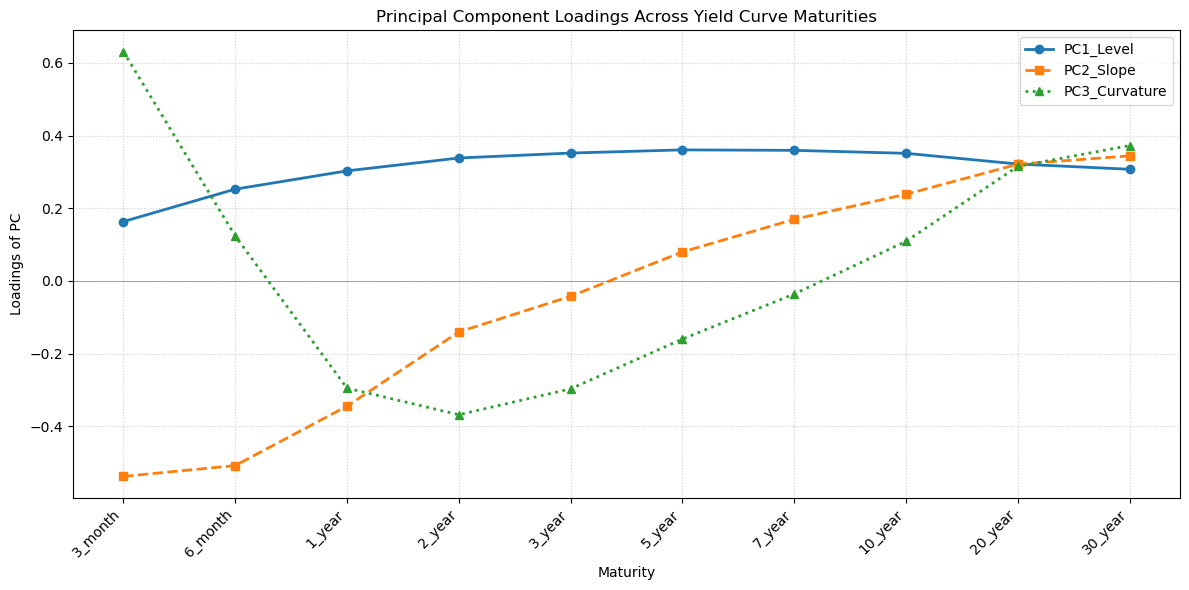

In [24]:
# Visualize the loadings 
fig = plt.figure(figsize=(12, 6))

# Define ordinal x-axis values and simplified labels
new_x_ordinal = np.arange(len(factor_loadings_df.index))
maturity_labels = factor_loadings_df.index

# Plot the three components
plt.plot(new_x_ordinal, factor_loadings_df['PC1_Level'], marker='o', linestyle='-', label='PC1_Level', linewidth=2)
plt.plot(new_x_ordinal, factor_loadings_df['PC2_Slope'], marker='s', linestyle='--', label='PC2_Slope', linewidth=2)
plt.plot(new_x_ordinal, factor_loadings_df['PC3_Curvature'], marker='^', linestyle=':', label='PC3_Curvature', linewidth=2)


plt.title('Principal Component Loadings Across Yield Curve Maturities')
plt.xlabel('Maturity')
plt.ylabel('Loadings of PC')
plt.xticks(new_x_ordinal, maturity_labels, rotation=45, ha='right')
plt.axhline(0, color='grey', linestyle='-', linewidth=0.5)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show() 


---

## 4. Stationarity Testing <a class="anchor" id="4"></a>

In [20]:
# Stationarity Check ADF
for factor in factor_df.columns:
    adf_result = adfuller(factor_df[factor])
    p_value = adf_result[1]
    if p_value <= 0.5:
        print(f"Factor: {factor} | ADF p-value: {p_value} | Stationarity: is stationary")
    else:
        print(f"Factor: {factor} | ADF p-value: {p_value} | Stationarity: is NOT stationary")


Factor: Level_Beta | ADF p-value: 6.523836142807537e-30 | Stationarity: is stationary
Factor: Slope_Beta | ADF p-value: 9.470154951397456e-09 | Stationarity: is stationary
Factor: Curvature_Beta | ADF p-value: 1.0426588477799883e-11 | Stationarity: is stationary


Results:

The Augmented Dickey-Fuller (ADF) tests confirmed that all three factor time series (Level, Slope, and Curvature) are statistically stationary (p-value $\le 0.05$).This result is crucial as it validates the core assumption of the Vector Autoregression (VAR) model, meaning we can directly proceed with fitting the model without any further differencing.

---

## 5. Dynamic Nelson-Siegel Model: Modeling and Forecasting <a class="anchor" id="5"></a>

Since we are working with time series data, we cannot simply perform a random train-test split without risking data leakage and disrupting the temporal order. Instead, I will use a rolling window validation approach, which involves sequentially training on a fixed-size window of past data and forecasting the subsequent period. This method accurately reflects real-world forecasting scenarios and allows us to evaluate model performance and stability over different regimes.

I will use train window of 750 days (about 3 year of trading days) and a predict horizon of 120 days (about 6 month), with step size of 20 days (days to move the origin each cycle). This is consistent with the backtest in AR, and VAR models in previous notebook.

In [37]:
# Backtest Parameters
train_window = 750  # in days, about 3 years of trading data 
h = 120             # forecast horizon in days, about 6 month of trading data
step_size = 20      # days to move the origin each cycle

In [56]:
# Backtest setup
n = len(factor_df)
max_lags = 10 

# Containers to match user's requested structure, storing DataFrames
dns_forecasts_list = [] # Stores DataFrames of forecasted yield changes
dns_actuals_list = []   # Stores DataFrames of actual yield changes
dns_origin_dates = []   # Stores the date of the last data point used for each forecast

In [57]:
# Loop through the data, rolling the fixed-size training window forward
for start_idx in range(0, n - train_window - h + 1, step_size):
    
    train_end_idx = start_idx + train_window
    forecast_end_idx = train_end_idx + h
    
    # 1. Extract train/test subset using FACTOR scores
    factor_train_data = factor_df.iloc[start_idx:train_end_idx]
    
    # Extract actual YIELD changes for the test period (for storing)
    actual_yield_changes_df = yield_changes_df.iloc[train_end_idx:forecast_end_idx]
    
    # Get the date of the forecast origin (last day of data used)
    if train_end_idx > 0 and train_end_idx <= n:
        origin_date = factor_df.index[train_end_idx - 1] 
        dns_origin_dates.append(origin_date)
    
    # 2. Initialize VAR model and perform dynamic lag selection
    model = VAR(factor_train_data)
    try:
        # Select order up to max_lags
        sel_order = model.select_order(maxlags=max_lags)
        
        # Choose optimal lag based on BIC (or AIC), fallback to lag=1 if selection fails
        lag_order = sel_order.bic if sel_order.bic is not None else 1
        lag_order = int(lag_order) 
        
        # Ensure lag is between 1 and max_lags
        lag_order = max(1, min(lag_order, max_lags))
        
    except Exception as e:
        # Fallback if VAR estimation or selection fails (e.g., singular matrix)
        print(f"Lag selection failed at start_idx {start_idx}: {e}. Falling back to lag=1.")
        lag_order = 1
    
    # 3. Fit VAR on factor training data
    try:
        results_current = model.fit(lag_order, trend='c') 
    except Exception as e:
        print(f"Error fitting VAR model at start_idx {start_idx} with lag={lag_order}. Skipping: {e}")
        continue

    # 4. Forecast factor changes for the full horizon (h steps)
    lag_input = factor_train_data.values[-lag_order:]
    forecast_factor_changes_array = results_current.forecast(lag_input, steps=h)

    # 5. Project factors back to unscaled yield changes
    forecast_yield_changes_scaled = forecast_factor_changes_array @ pca_loadings
    forecast_yield_changes_array = scaler.inverse_transform(forecast_yield_changes_scaled)
    
    # 6. Create DataFrame with dates and columns, and append results
    forecast_dates = actual_yield_changes_df.index
    
    dns_forecast_df = pd.DataFrame(
        forecast_yield_changes_array, 
        index=forecast_dates, 
        columns=yield_changes_df.columns
    )
    
    # Append results (DataFrames)
    dns_forecasts_list.append(dns_forecast_df)
    dns_actuals_list.append(actual_yield_changes_df)


c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

In [58]:
# Convert lists to DataFrames for evaluation
dns_forecasts = pd.concat(dns_forecasts_list)
dns_actuals = pd.concat(dns_actuals_list)

In [59]:
# Compute RMSE per term
dns_rmse_per_term = np.sqrt(((dns_forecasts - dns_actuals) ** 2).mean())
print("Dynamic Nelson-Siegel Model RMSE per term:\n", dns_rmse_per_term)

Dynamic Nelson-Siegel Model RMSE per term:
 3_month    0.042684
6_month    0.043615
1_year     0.062427
2_year     0.078163
3_year     0.078966
5_year     0.076886
7_year     0.074640
10_year    0.068754
20_year    0.062520
30_year    0.061029
dtype: float64


In [64]:
# Compute overall RMSE (mean over all PCs)
dns_overall_rmse = np.sqrt(mean_squared_error(dns_forecasts, dns_actuals))

In [65]:
print("\n--- 7. Model Performance Summary (Fixed-Size Rolling Backtest) ---")
print(f"Total Backtest Blocks: {len(dns_actuals_list)}")
print(f"Total Forecasted Points: {len(dns_forecasts)}")
print(f"**Overall Yield Change RMSE (across all maturities): {dns_overall_rmse:.5f}")
print("This RMSE is the average daily forecast error across all forecast windows and maturities.")


--- 7. Model Performance Summary (Fixed-Size Rolling Backtest) ---
Total Backtest Blocks: 42
Total Forecasted Points: 5040
**Overall Yield Change RMSE (across all maturities): 0.06619
This RMSE is the average daily forecast error across all forecast windows and maturities.


---

## 6. Results and Next Steps <a class="anchor" id="6"></a>

### 6.1 Model Comparisons <a class="anchor" id="6a"></a>

| Model | Overall RMSE | Train Window | Prediction Horizon | Step Size | Notes |
|-------|--------------:|-------------:|-------------------:|----------:|-------|
| AR    | 0.066178     | 750          | 120                | 20        | p=5 |
| VAR   | 0.066175     | 750          | 120                | 20        | lag determined by AIC/BIC per training window |
| DNS   | 0.066190     | 750          | 120                | 20        | Dynamic Nelson–Siegel (factors extracted by PCA (PC1: Level, PC2: Slope, PC3: Curvature) + VAR) |

A key finding from our rolling backtest was the observation that the DNS model's predictive accuracy, measured by the Root Mean Square Error (RMSE), was highly comparable to that of simpler AR or pure VAR models applied directly to the raw yield changes ($\Delta Y$).
<br>This similarity highlights the pervasive *Random Walk Hurdle* in high-frequency financial data. For daily or short-horizon forecasts, the additional complexity and structural information of the DNS model provided minimal predictive gain. The noise inherent in short-term yield changes often overwhelms the explanatory power of sophisticated time-series structures.

---

### 6.2 Predicted Yield V.S Actual Yield <a class="anchor" id="6b"></a>

Visualize the forecasted yield curves alongside the actual yield data for Dynamic Nelson-Siegel Model.

In [67]:
# Show the first prediction
dns_forecasts.index[0]

Timestamp('2021-12-31 00:00:00')

In [68]:
# Pick the target date to visualize, it should be later then Dec 31st 2021
# Feel free the change and play around
target_date = ('2024-04-04')

 # Get actual yields
yield_actual = yield_df.loc[target_date, :] 

In [69]:
# Get the positon of target date
pos = yield_df.index.get_loc(target_date)

In [70]:
# Get the yield changes prediction of our target date (first prediction)
dns_yield_changes_pred = dns_forecasts.loc[target_date].iloc[0, :]  

In [71]:
# Add the yield changes to the original yield data
dns_yield_pred = yield_df.iloc[pos - 120, :] + dns_yield_changes_pred 

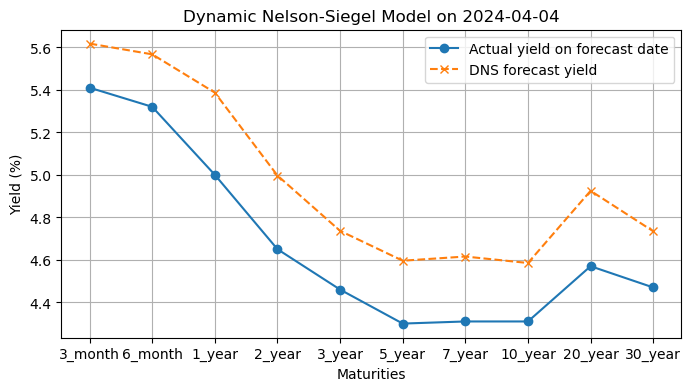

In [76]:
# Vislualize the prediction vs actual yield curve

plt.figure(figsize=(8, 4))
plt.plot(yield_df.columns, yield_actual, 'o-', label='Actual yield on forecast date')
plt.plot(yield_df.columns, dns_yield_pred, 'x--', label='DNS forecast yield')
plt.title("Dynamic Nelson-Siegel Model on 2024-04-04")
plt.xlabel("Maturities")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid()

plt.show()

### 6.3 Visualize RMSE over time <a class="anchor" id="6c"></a>

To understand how the model performs under different yield curve changes, I will visualize our RMSE over the predicted horizon. First I will bring back the plot of actual yield curves over between 2019 to 2025.

In [86]:
# --- 1) Define maturities  ---
maturity_map = {'3_month': 3/12, '6_month': 6/12, '1_year': 1, '2_year': 2, '3_year': 3, '5_year': 5, '7_year': 7, '10_year': 10, 
                '20_year': 20, '30_year': 30
                }

maturity_labels = list(maturity_map.keys())

# --- 2) Create custom staggered tick labels ---
tick_positions = list(maturity_map.values())
custom_tick_text = []
for label in maturity_labels:
    if label == '3_month':
        custom_tick_text.append('')             # hide 3_month if desired
    elif label in ['6_month', '2_year', '7_year']:
        custom_tick_text.append(f"{label}<br>") # staggered (upper) row
    else:
        custom_tick_text.append(label)          # standard (lower) row

# --- 3) Prepare data (drop 1_month, format index, rename columns) ---
df_plot_working = yield_df.copy()

# Drop 1_month if present
if '1_month' in df_plot_working.columns:
    df_plot_working = df_plot_working.drop(columns=['1_month'])

# Ensure index is datetime and convert to clean string for slider
df_plot_working.index = pd.to_datetime(df_plot_working.index)
df_plot_working.index = df_plot_working.index.strftime('%Y-%m-%d')

# Rename columns from labels to numeric maturity times
df_plot_working = df_plot_working.rename(columns=maturity_map)

# Melt to long format for Plotly animation
df_long = df_plot_working.reset_index().melt(
    id_vars='index',
    var_name='Maturity_Time',
    value_name='Yield'
).rename(columns={'index': 'Date'})

# Ensure Maturity_Time is numeric (float) for X axis
df_long['Maturity_Time'] = df_long['Maturity_Time'].astype(float)

# --- 4) Create animated Plotly figure ---
fig = px.line(
    df_long,
    x='Maturity_Time',
    y='Yield',
    animation_frame='Date',
    line_group='Date',
    markers=True,
    title='U.S. Treasury Yield Curve Evolution (2019-01 to 2025-10)'
)

# --- 5) Layout and axis customization ---
fig.update_layout(
    width=1000,
    margin=dict(l=40, r=40, t=80, b=180),
    title_x=0.5
)

fig.update_xaxes(
    tickvals=tick_positions,
    ticktext=custom_tick_text,
    title_text=None,
    tickangle=-45,
    automargin=False
)

fig.update_yaxes(
    range=[0, 6.5],
    title_text='Yield (%)'
)

# Custom trace appearance and hovertemplate
fig.update_traces(
    line=dict(color='blue', width=3),
    hovertemplate="<b>Date: %{customdata[0]}</b><br>Yield: %{y:.2f}%<extra></extra>",
    customdata=df_long[['Date']]
)

# Animation speed tuning
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 50
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 20

fig.show()

Visualize RMSE changes (Aggregated the errors of all terms) over time 

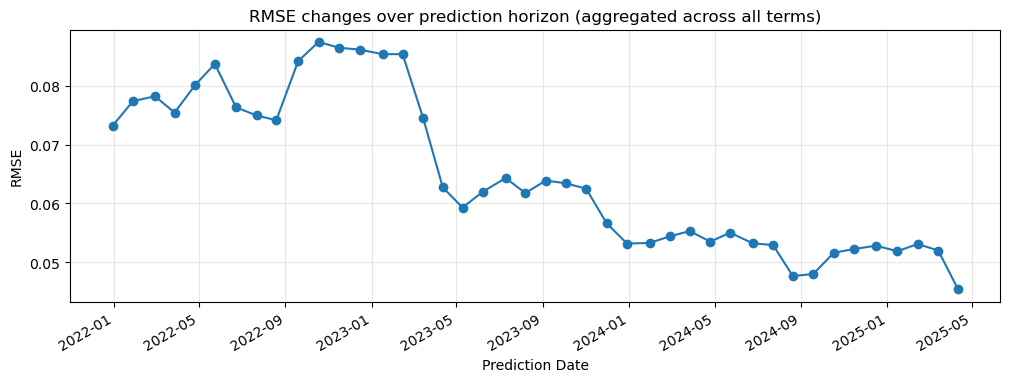

In [85]:
# RMSE (aggregate across terms for each origin)
# We need to compute RMSE for each origin (training window). dns_forecasts_list and dns_actuals_list hold per-origin DataFrames.
per_origin_rmse = []
origin_dates = dns_origin_dates  # list of origin dates (one per loop)

for f_df, a_df in zip(dns_forecasts_list, dns_actuals_list):
    # align just in case
    f_df, a_df = f_df.align(a_df)
    # RMSE aggregated over horizon and tenors for this origin
    mse = ((f_df - a_df) ** 2).values.mean()
    per_origin_rmse.append(np.sqrt(mse))

per_origin_rmse = pd.Series(per_origin_rmse, index=origin_dates)

# Plot per-origin RMSE over time
plt.figure(figsize=(12,4))
per_origin_rmse.plot(marker='o', linestyle='-')
plt.title('RMSE changes over prediction horizon (aggregated across all terms)')
plt.xlabel('Prediction Date')
plt.ylabel('RMSE')
plt.grid(alpha=0.3)

Insights:

This time‑varying RMSE provides the most valuable diagnostic from the backtest — it closely tracks realized economic volatility. The sharp RMSE spike from 2022 through March 2023 reflects severe market disruption during the Fed’s rapid rate‑hiking cycle. That structural break in yield dynamics rendered the VAR transition matrix (Φ), trained on predominantly low‑rate history, unable to predict the speed and magnitude of daily moves — hence the model consistently lagged and produced its largest errors.

The subsequent steady RMSE decline from March 2023 through May 2025 shows the rolling‑window re‑estimation working as intended. As the 750‑day window gradually dropped older low‑volatility data and incorporated more observations from the new higher‑rate regime, the model relearned the updated relationships among Level, Slope, and Curvature, improving forecast accuracy as expectations re‑anchored.

In short: the model is fragile during abrupt regime shifts but adapts and regains robustness once the training window reflects the new regime.

---


### Analysis Summary & Next Step
DNS Model Performance & InsightsOur project successfully implemented the Dynamic Nelson-Siegel (DNS) framework, combining Principal Component Analysis (PCA) to define the structural factors (Level, Slope, Curvature, or $\mathbf{L}$) with a Vector Autoregression (VAR) model to capture their dynamics.

Performance vs. Simplicity
<br>A key finding from our rolling backtest was the observation that the DNS model's predictive accuracy, measured by the Root Mean Square Error (RMSE), was highly comparable to that of simpler AR or pure VAR models applied directly to the raw yield changes ($\Delta Y$).This similarity highlights the pervasive Random Walk Hurdle in high-frequency financial data. For daily or short-horizon forecasts, the additional complexity and structural information of the DNS model provided minimal predictive gain. The noise inherent in short-term yield changes often overwhelms the explanatory power of sophisticated time-series structures.

The Value of Structural Decomposition
<br>Despite the lack of RMSE superiority, the DNS approach provided immense value through structural decomposition.The model translates the raw yield changes into three economically significant factors ($\Delta \beta$).The system is defined by the core equation: $\Delta \hat{Y} = \mathbf{L} \cdot \text{VAR}(\Delta \beta)$.This approach grants our model economic interpretability, allowing us to explain movements in the yield curve by attributing changes to shifts in the Level, Slope, or Curvature. This understanding of risk exposure is often more valuable for portfolio management than a marginal improvement in a purely statistical point forecast.

Model Performance Over Time
<br>The model is fragile at abrupt regime shifts but adapts once the training window reflects the new regime. The error spikes sharply from 2022 through Mar‑2023 during the Fed’s rapid rate‑hiking cycle, indicating a structural break that rendered the VAR transition matrix (Φ)—trained on low‑rate history—unable to track the speed and magnitude of daily moves. The steady RMSE decline from Mar‑2023 through May‑2025 shows the rolling 750‑day re‑estimation working: as older low‑volatility data are dropped and newer higher‑rate observations enter the window, the model relearns factor dynamics and forecast accuracy improves. 

Path to Improved Prediction / Next Steps
<br>Our analysis confirms that to significantly reduce the RMSE, especially at longer horizons, we must incorporate information external to the yield curve itself.Our next logical step is to introduce relevant macroeconomic indicators (e.g., inflation, unemployment, central bank policy rates) into the time-series model. 